In [3]:
from datetime import datetime, timedelta
import numpy as np
import re
import random
import os
import time
import dill
import yaml
from environment import MiniWoBEnvironment
from utils import find_ref, save_trajectory, name_file, parse_response

In [4]:
from google.cloud import aiplatform
import vertexai.preview
from vertexai.preview.generative_models import GenerativeModel, Part, ChatSession

from PIL import Image
from google.cloud import storage

BUCKET = 'miniwobimages'

project_id = "cs224n-420704"
aiplatform.init(project=project_id)
vertexai.preview.init()
model = GenerativeModel(model_name="gemini-1.5-pro-preview-0514")
client = storage.Client(project=project_id)
bucket = client.get_bucket(BUCKET)

In [5]:
with open('config.yaml') as f: config = yaml.safe_load(f)
API_KEY = config['api_key']
MODEL="meta-llama/Llama-3-70b-chat-hf"
SAVE_TO_FOLDER = 'trajectories_train'
DATES = []
MONTHS = ['December', 'November', 'October'
          , 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']

### Choose Date

In [55]:
def get_trajectory_choose_date():
    env_type = 'choose-date'
    action_type = 'CLICK_ELEMENT'
    actions, doms, images, times = [], [], [], []

    def append(action,dom,image):
        actions.append(action)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode=None)
    start_time = time.time()
    observation, info = env.reset()

    goal = observation['utterance']
    date = re.search('Select (.*) as the date', goal).group(1)
    date = datetime.strptime(date, '%m/%d/%Y')
    
    if date in DATES:
        raise Exception('Date already in list')
    DATES.append(date)
    prev_times = 12 - date.month
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    
    action = env.create_action(action_type, ref=5)
    observation, reward, terminated, truncated, info = env.step(action)
    observation, reward, terminated, truncated, info = env.step(action)
    
    action_txt = 'Click on datepicker - {} 5'.format(action_type)
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    
    for i in range(prev_times):
        if i==0:
            ref=10
        else:
            ref = find_ref(dom,'Prev')
        action = env.create_action(action_type, ref=ref)
        observation, reward, terminated, truncated, info = env.step(action)
        
        action_txt = 'Click on Prev to get to the month of {}- {} {}'.format(MONTHS[i+1], action_type, ref)
        dom = observation['dom_elements']
        image = observation['screenshot']
        append(action_txt, dom, image)
    
    day = str(date.day)
    ref = find_ref(dom, day)
    
    action = env.create_action(action_type, ref=ref)
    observation, reward, terminated, truncated, info = env.step(action)

    action_txt = 'Click on day {} - {} {}'.format(day, action_type, ref)
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    
    ref = find_ref(dom, 'Submit')
    
    action = env.create_action(action_type, ref=ref)
    observation, reward, terminated, truncated, info = env.step(action)

    action_txt = 'Click on Submit - {} {}'.format(action_type, ref)
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    env.close()
    save_trajectory(actions, doms, images, times, env_type, reward, goal)
    return 

In [51]:
def get_trajectories_choose_date():
    while len(DATES) < 100:
        try:
            get_trajectory_choose_date()
        except Exception as error:
            print(error)
            continue
get_trajectories_choose_date()

saved trajectory in file trajectories_train/choose-date/choose-date100.pkd
saved trajectory in file trajectories_train/choose-date/choose-date100.pkd
saved trajectory in file trajectories_train/choose-date/choose-date100.pkd


KeyboardInterrupt: 

### Book Flight

In [43]:
def ref2text(ref, dom):
    for element in dom:
        if element['ref'] == ref:
            text = element['text']
            return text
    

def get_trajectory_book_flight():   
    env_type = 'book-flight'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    fields = dict(observation['fields'])
    
    goal = observation['utterance']
    from_ = fields['from']
    to_ = fields['to']
    date = datetime.strptime(fields['date'], '%m/%d/%Y')
    criterion = fields['criterion']                               
    prev_times = 12 - date.month
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    action_type, ref, text = action_types[0], 7, ''
    action_txt = 'Click on From input field - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 7, from_
    action_txt = 'Type {} in From input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 20, ''
    action_txt = 'Click on autocomplete option {} - {} {}'.format(ref2text(ref, doms[-1]),action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 9, ''
    action_txt = 'Click on To input field - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 9, to_
    action_txt = 'Type {} in To input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 24, ''
    action_txt = 'Click on autocomplete option {} - {} {}'.format(ref2text(ref, doms[-1]),action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 13, ''
    action_txt = 'Click on datepicker - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    for i in range(prev_times):
        action_type, text = action_types[0], 'Prev'
        ref = find_ref(doms[-1], text)
        action_txt = 'Click on Prev to get to the month of {}- {} {}'.format(MONTHS[i+1], action_type, ref)
        execute_action(action_type, ref, text, action_txt)
    
    action_type, text = action_types[0], str(date.day)
    ref = find_ref(doms[-1], text)
    action_txt = 'Click on day {} - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, text = action_types[0], 'Search'
    ref = find_ref(doms[-1], text)
    action_txt = 'Click on {} - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    instruction = 'Find the {} flight'.format(criterion)
    print(instruction)
    prompt = create_prompt(instruction, doms[-1])
    
    chat = model.start_chat(response_validation = False)
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type = action_types[0]
    text = ref2text(ref, doms[-1])
    action_txt = 'Click on button {} - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    print(reward)
    env.close()
    return save_trajectory(actions, doms, images, times, env_type, reward, goal)

trajectory = get_trajectory_book_flight()

Find the shortest flight
Action description: Click the button to "Book flight for $364" because it has the shortest duration of 0h 17m.

Dom element ref number: 271 

0.6523333333333333


TypeError: can only concatenate list (not "str") to list

In [41]:
def create_prompt(goal,dom):

    part1 = '''You are a web-agent capable of reasoning to make decisions based on the information
    you are given. You are able to click on website buttons to select the best option based on the
    criterion provided. For example, you are able to compare durations, to select the shortest flight.

You are given the following goal: 
{}
You observe the following DOM elements from the web-page HTML: {}'''.format(goal,dom)
    part2 = '''
Start by comparing the different choices available and then find
the best answer. Provide your answer for the ONE next action in the following format:

Action description:
'''
    part3 = ''' Once you identified the next action to take, identify the ref number of the element
    on which you need to perform the action. Write your answer in the following format:
    
    Dom element ref number:
    
    \n'''
    
    return part1+part2+part3
#prompt = create_prompt('Find the cheapest flight', trajectory['states'][-1]['dom_elements'])

In [33]:
chat = model.start_chat()
response = chat.send_message(prompt).text
response

'Action description: Click the button to book the flight for $499, as it is the cheapest option.\n\n    Dom element ref number: 175 \n'

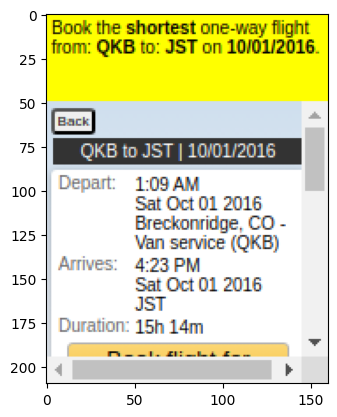

In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(trajectory['states'][-2]['screenshot'])

In [45]:
test = dill.load(open('trajectories_train/book-flight/book-flight031.pkd','rb'))
print(test['utterance'])
print(test['reward'])
[x['action'] for x in test['states']]

Book the cheapest one-way flight from: Akiak, AK to: Dutch Harbor, AK on 11/03/2016.
0.0


['',
 'Click on From input field - CLICK_ELEMENT 7',
 'Type Akiak, AK in From input field - TYPE_TEXT 7',
 'Click on autocomplete option Akiak, AK (AKI) - CLICK_ELEMENT 20',
 'Click on To input field - CLICK_ELEMENT 9',
 'Type Dutch Harbor, AK in To input field - TYPE_TEXT 9',
 'Click on autocomplete option  - CLICK_ELEMENT 24',
 'Click on datepicker - CLICK_ELEMENT 13',
 'Click on Prev to get to the month of November- CLICK_ELEMENT 31',
 'Click on day 3 - CLICK_ELEMENT 160',
 'Click on Search - CLICK_ELEMENT 15',
 'Click on button Search - CLICK_ELEMENT 15']

### Search Engine

In [32]:
from math import ceil

def get_page_link(page_no, dom):
    text = str(page_no)
    for element in dom:
        if element['classes'] =='page-link' and element['text'] == text:
            return element['ref']
        
def search_page(text, dom):
    for element in dom:
        if element['classes'] =='search-title' and element['text'] == text:
            return element['ref']
    return 0

def get_trajectory_search_engine():   
    env_type = 'search-engine'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    fields = dict(observation['fields'])

    goal = observation['utterance']
    query = fields['query']
    rank = int(fields['rank'])
    #page = ceil(rank/3) # will not be used to generalize to other environments
    item_not_found = True
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    action_type, ref, text = action_types[0], 5, ''
    action_txt = 'Click on textbox - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 5, query
    action_txt = 'Type {} in textbox - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 6, ''
    action_txt = 'Click on the Search button - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)

    page = 1
    while item_not_found:
        ref = search_page(query, doms[-1])
        if ref > 0:
            item_not_found = False
        else:
            page +=1
            ref = get_page_link(page, doms[-1])
            action_type, text = action_types[0], ''
            action_txt = 'Go to page {} because {} was not found on page {} - {} {}'.format(
                page, query, page-1, action_type, ref)
            execute_action(action_type, ref, text, action_txt)
        
        
    action_type, text = action_types[0], ''
    action_txt = 'Click Search Title {} - {} {}'.format(query,action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    env.close()
    return save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)

get_trajectory_search_engine()

0.87615
saved trajectory in file trajectories_train/search-engine/search-engine102.pkd


{'utterance': 'Use the textbox to enter "Cheree" and press "Search", then find and click the 4th search result.',
 'reward': 0.87615,
 'states': [{'time': 0,
   'action': '',
   'dom_elements': ({'ref': 1,
     'parent': 0,
     'left': array([0.], dtype=float32),
     'top': array([0.], dtype=float32),
     'width': array([500.], dtype=float32),
     'height': array([210.], dtype=float32),
     'tag': 'body',
     'text': '',
     'value': '',
     'id': '',
     'classes': '',
     'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
     'fg_color': array([0., 0., 0., 1.], dtype=float32),
     'flags': array([1, 0, 0, 0], dtype=int8)},
    {'ref': 2,
     'parent': 1,
     'left': array([0.], dtype=float32),
     'top': array([0.], dtype=float32),
     'width': array([160.], dtype=float32),
     'height': array([210.], dtype=float32),
     'tag': 'div',
     'text': '',
     'value': '',
     'id': 'wrap',
     'classes': '',
     'bg_color': array([1.

In [38]:
test = dill.load(open('trajectories_train/search-engine/search-engine002.pkd','rb'))
[x['action'] for x in test['states']]

['',
 'Click on textbox - CLICK_ELEMENT 5',
 'Type Keneth in textbox - TYPE_TEXT 5',
 'Click on the Search button - CLICK_ELEMENT 6',
 'Go to page 2 because Keneth was not found on page 1 - CLICK_ELEMENT 24',
 'Click on Search Title Keneth - CLICK_ELEMENT 38']

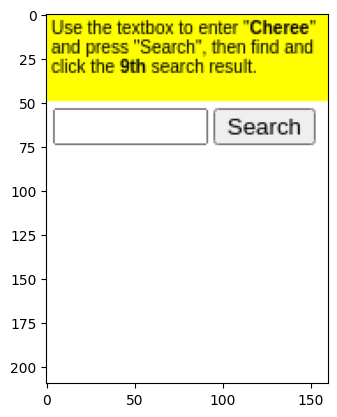

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(test['states'][0]['screenshot'].astype(int))

In [216]:
def count_reward(env_name):
    path = 'trajectories_train/'+env_name
    files = os.listdir(path)
    files = [x for x in files if os.path.isfile(os.path.join(path,x))]
    reward = 0
    n_rewards = 0
    n_pos_rewards =0
    for i in range(len(files)):
        filepath = os.path.join(path, files[i])
        trajectory = dill.load(open(filepath, 'rb'))
        traj_reward = trajectory['reward']
        if traj_reward is not None:
            n_rewards +=1
            if traj_reward >0:
                reward += (traj_reward+1)/2
                n_pos_rewards +=1
    print(n_pos_rewards, len(files))      
    return reward/n_pos_rewards
count_reward('social-media')

106 126


0.8312908805031446

### Email inbox

In [117]:
def search_item(text, cls, dom):
    for element in dom:
        if element['classes'] ==cls and  element['text'] == text:
            return element['ref']

def find_ref(dom, s):
    for element in dom:
        if element['text'] == s:
            return element['ref']

def get_trajectory_email_inbox():
    env_type = 'email-inbox'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    fields = dict(observation['fields'])
    
    goal = observation['utterance']
    task = fields['task']
    print(task)
    by = fields['by']
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    if task in ['delete', 'star']:
        env.close()
        return 0,0
        instruction = '{} the email message by {}'.format(task.capitalize(), by)
        print(instruction)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Click on {} icon - {} {}'.format(task, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
    else:
        ref = search_item(by, 'email-sender', doms[-1])
        action_type, text = action_types[0], ''
        action_txt = 'Click on the thread by {} - {} {}'.format(by,action_type, ref)
        execute_action(action_type, ref, text, action_txt)
        
        ref = find_ref(doms[-1], task.capitalize())
        action_type, text = action_types[0], ''
        action_txt = 'Click on the {} icon - {} {}'.format(task.capitalize(), action_type, ref)
        execute_action(action_type, ref, text, action_txt)
        
        if task == 'forward':
            field = 'to'
        else:
            field = 'message'
        text = fields[field]
            
        instruction = 'Enter text {} in the {} field'.format(text,field.capitalize())
        print(instruction)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type = action_types[1]
        action_txt = 'Type {} on {} field - {} {}'.format(text, field.capitalize(), action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
        action_type, text = action_types[0], ''
        
    print(reward)
    env.close()
    save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_email_inbox()

reply
Enter text Dignissim ultricies. in the Message field
Action description: Enter text 'Dignissim ultricies.' in the 'reply-text' textarea. 

Dom element ref number: 93 

saved trajectory in file trajectories_train/email-inbox/email-inbox002.pkd


{'utterance': 'Find the email by Pandora and reply to them with the text "Dignissim ultricies.".',
 'reward': 0.0,
 'states': [{'time': 0,
   'action': '',
   'dom_elements': ({'ref': 1,
     'parent': 0,
     'left': array([0.], dtype=float32),
     'top': array([0.], dtype=float32),
     'width': array([500.], dtype=float32),
     'height': array([210.], dtype=float32),
     'tag': 'body',
     'text': '',
     'value': '',
     'id': '',
     'classes': '',
     'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
     'fg_color': array([0., 0., 0., 1.], dtype=float32),
     'flags': array([1, 0, 0, 0], dtype=int8)},
    {'ref': 2,
     'parent': 1,
     'left': array([0.], dtype=float32),
     'top': array([0.], dtype=float32),
     'width': array([160.], dtype=float32),
     'height': array([210.], dtype=float32),
     'tag': 'div',
     'text': '',
     'value': '',
     'id': 'wrap',
     'classes': '',
     'bg_color': array([1., 1., 1., 1.], dtyp

In [118]:
test = dill.load(open('trajectories_train/email-inbox/email-inbox002.pkd','rb'))
[x['action'] for x in test['states']]

['',
 'Click on the thread by Pandora - CLICK_ELEMENT 37',
 'Click on the Reply icon - CLICK_ELEMENT 78',
 'Type Dignissim ultricies. on Message field - TYPE_TEXT 93']

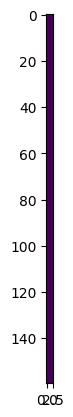

In [94]:
plt.imshow(image.astype(int))

In [95]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

### Click checkboxes

In [151]:
def get_trajectory_click_checkboxes_soft():
    env_type = 'click-checkboxes-soft'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    print(goal)
    n_clicks =len([x for x in observation['fields'] if 'target' in x[0]])
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    
    prompt = create_prompt(goal, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    text = ref2text(ref, doms[-1])
    action_type = action_types[0]
    action_txt = 'Click on checkbox next to the word {} - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    while True:
        prompt = 'Keeping your goal in mind, what would be your next step? If no more steps, write "DONE"'
        response = chat.send_message(prompt).text
        print(response)
        
        if 'DONE' in response:
            break
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        text = ref2text(ref, doms[-1])
        action_type = action_types[0]
        action_txt = 'Click on {} box - {} {}'.format(text, action_type, ref)
        if 'Submit' in response:
            action_txt = 'Click on the Submit button - {} {}'.format(action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
            
    #action_type, ref, text = action_types[0], find_ref(doms[-1], 'Submit'), ''
    #action_txt = 'Click on the Submit button - {} {}'.format(action_type, ref)
    #reward = execute_action(action_type, ref, text, action_txt)
    print(reward)
    env.close()
    save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_click_checkboxes_soft()

Select words similar to crimson, corrupt, frightened, carve and click Submit.
Action description: Click the checkbox next to the word 'red' because it is similar to 'crimson'.
Dom element ref number: 8 

Action description: Click the checkbox next to the word 'wicked' because it is similar to 'corrupt'.
Dom element ref number: 10 

Action description: Click the checkbox next to the word 'frightened' because it matches the given word.
Dom element ref number: 14 

Action description: Click the checkbox next to the word 'cut' because it is similar to 'carve'.
Dom element ref number: 16 

Action description: Click the 'Submit' button to submit the selected words.
Dom element ref number: 17 

DONE 

0.09940000000000004
saved trajectory in file trajectories_train/click-checkboxes-soft/click-checkboxes-soft005.pkd


### Click tab2 hard

In [181]:
def search_item(text, cls, dom):
    for element in dom:
        if element['classes'] ==cls and  element['text'] == text:
            return element['ref']
    return 0

def get_trajectory_click_tab2_hard():
    env_type = 'click-tab-2-hard'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    fields = dict(observation['fields'])
    target = fields['target']
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    ref1 = 0
    tab_no = 1
    while ref1 == 0:
        ref1 = search_item(target, 'alink', doms[-1])
        if ref1 > 0:
            break
        tab_no += 1
        action_type, text = action_types[0], str(tab_no)
        ref = search_item(text, 'ui-tabs-anchor', doms[-1])
        action_txt = 'Click on tab number {} because the link was not found in tab {} - {} {}'.format(
            tab_no, tab_no - 1, action_type, ref)
        execute_action(action_type, ref, text, action_txt)
    
    action_type, text = action_types[0], target
    action_txt = 'Click on link {}  - {} {}'.format(target, action_type, ref1)
    reward = execute_action(action_type, ref1, text, action_txt)
    print(reward)
    env.close()
    save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_click_tab2_hard()

{'target': 'Senectus'}
0.83985
saved trajectory in file trajectories_train/click-tab-2-hard/click-tab-2-hard006.pkd


In [182]:
test = dill.load(open('trajectories_train/click-tab-2-hard/click-tab-2-hard006.pkd','rb'))
[x['action'] for x in test['states']]

['',
 'Click on tab number 2 because the link was not found in tab 1 - CLICK_ELEMENT 8',
 'Click on tab number 3 because the link was not found in tab 2 - CLICK_ELEMENT 10',
 'Click on tab number 4 because the link was not found in tab 3 - CLICK_ELEMENT 12',
 'Click on tab number 5 because the link was not found in tab 4 - CLICK_ELEMENT 14',
 'Click on tab number 6 because the link was not found in tab 5 - CLICK_ELEMENT 16',
 'Click on link Senectus  - CLICK_ELEMENT 55']

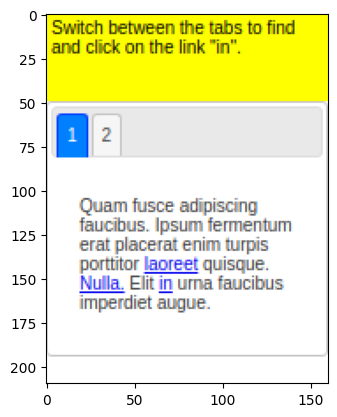

In [171]:
plt.imshow(image)

### Social media

In [213]:
def get_trajectory_social_media():
    env_type = 'social-media'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    fields = dict(observation['fields'])
    user = fields['user']
    button = fields['button']
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    
    if button in ['Like', 'Reply', 'Retweet']:
        prompt = create_prompt(goal, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Look for the tweet by {} and click on the {} button - {} {}'.format(
            user, button, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
    else:
        instruction = 'For user {}, click on the MORE button (3 dots)'.format(user)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Look for the tweet by {} and click on the MORE button (3 dots) - {} {}'.format(
            user, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)

        prompt = create_prompt(goal, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Select the {} option from the MORE dropdown menu - {} {}'.format(
            button, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)

    print(reward)
    env.close()
    save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 

get_trajectory_social_media()

Action description: Click on the MORE button (3 dots) belonging to user @michel.

Dom element ref number: 55 

Action description: Click on the "Copy link to Tweet" button that appears in the MORE options for user @michel.

Dom element ref number: 97 

0.43553333333333333
saved trajectory in file trajectories_train/social-media/social-media009.pkd


In [203]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

In [232]:
def analyse_social_media():
    path = 'trajectories_gemini/social-media-some'
    files = os.listdir(path)
    files = [x for x in files if os.path.isfile(os.path.join(path,x))]
    score = 0
    reward = 0
    n_rewards = 0
    for i in range(len(files)):
        filepath = os.path.join(path, files[i])
        trajectory = dill.load(open(filepath, 'rb'))
        reward = trajectory['reward']
        goal = trajectory['utterance']
        print(goal,reward)         
    return
analyse_social_media()

Click the "Share" button on 5 posts by @feugiat and then click Submit. -1.0
Click the "Share" button on 1 post by @nathalie and then click Submit. 0.0
Click the "Share" button on 2 posts by @karrie and then click Submit. 0.0
Click the "Reply" button on 1 post by @enola and then click Submit. 0.0
Click the "Retweet" button on 3 posts by @nunc and then click Submit. -1.0
Click the "Like" button on 5 posts by @ashlea and then click Submit. -1.0
Click the "Share" button on 1 post by @cierra and then click Submit. 0.65515
Click the "Share" button on 3 posts by @nisl and then click Submit. -1.0
Click the "Like" button on 2 posts by @macie and then click Submit. -1.0
Click the "Reply" button on 2 posts by @riley and then click Submit. 0.0
Click the "Share" button on 1 post by @leonie and then click Submit. 0.0
Click the "Share" button on 9 posts by @lyda and then click Submit. -1.0
Click the "Share" button on 2 posts by @kasie and then click Submit. 0.0
Click the "Like" button on 1 post by @d

### Social media some

In [253]:
def get_trajectory_social_media_some():
    env_type = 'social-media-some'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    fields = dict(observation['fields'])

    user = fields['user']
    button = fields['button']
    amount = int(fields['amount'])

    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    
    instruction = 'Look for a tweet by {} and click on the {} button'.format(user, button)
    prompt = create_prompt(instruction, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type, text = action_types[0], ''
    action_txt = '{} - {} {}'.format(instruction, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    for _ in range(amount-1):
        prompt = 'Look for another tweet by {} and click on the {} button'.format(user,button)
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = '{} - {} {}'.format(instruction, action_type, ref)
        execute_action(action_type, ref, text, action_txt)

    text = 'Submit'
    action_type, ref = action_types[0], find_ref(doms[-1], text)
    action_txt = 'Click on the {} button - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    env.close()
    save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_social_media_some()

Action description: Click on the share button of a tweet by @emile. There are three tweets by @emile (ref 7, 47, 67). We will click on the share button of the first one (ref 13).

Dom element ref number: 13 

Action description: Click on the share button of a tweet by @emile. We already clicked on the share button of the first tweet by @emile.  We will click on the share button of the second tweet by @emile (ref 53).

Dom element ref number: 53 

Action description: Click on the share button of a tweet by @emile. We already clicked on the share button of the first two tweets by @emile.  We will click on the share button of the third tweet by @emile (ref 73).

Dom element ref number: 73 

0.5093
saved trajectory in file trajectories_train/social-media-some/social-media-some011.pkd


Click the "Retweet" button on 1 post by @cras and then click Submit.
0.0


['',
 'Look for a tweet by @cras and click on the Retweet button - CLICK_ELEMENT 11']

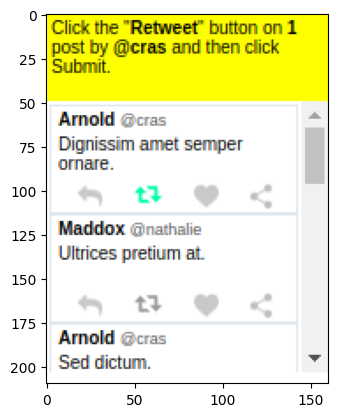

In [239]:
test = dill.load(open('trajectories_train/social-media-some/social-media-some003.pkd','rb'))
print(test['utterance'])
print(test['reward'])
plt.imshow(test['states'][-1]['screenshot'].astype(int))
[x['action'] for x in test['states']]

In [240]:
test['states'][0]['dom_elements']

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

### Use autocomplete

In [264]:
def get_trajectory_use_autocomplete():   
    env_type = 'use-autocomplete'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    fields = dict(observation['fields'])
    goal = observation['utterance']

    start = fields['start']
    end = fields.get('end','')
    if end:
        end = 'and ends with {}'.format(end)
    
    chat = model.start_chat(response_validation = False)
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))

    action_type, ref, text = action_types[0], 5, ''
    action_txt = 'Click on input field - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 5, start
    action_txt = 'Type {} in From input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    instruction = 'Click on the autocomplete menu option that starts with {} {}'.format(start,end)
    prompt = create_prompt(instruction, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type, text = action_types[0], ''
    action_txt = '{} - {} {}'.format(instruction,action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    text = 'Submit'
    action_type, ref = action_types[0], find_ref(doms[-1], text)
    action_txt = 'Click on the {} button - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    env.close()
    return save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
dom=get_trajectory_use_autocomplete()

Action description: Click on the autocomplete option Jamaica

Dom element ref number: 10 

0.7042999999999999
saved trajectory in file trajectories_train/use-autocomplete/use-autocomplete001.pkd


In [256]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

### Tic Tac Toe

In [20]:
def ref2classes(ref, dom):
    for element in dom:
        if element['ref'] == ref:
            return element['classes']

def update_board(board, dom, refs):
    for i in range(3):
        for j in range(3):
            c = ref2classes(refs[i,j])
            if c:
                board[i,j] = c[-1]
                refs[i,j] = 0
    return board

def get_trajectory_tic_tac_toe():   
    env_type = 'tic-tac-toe'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    goal = observation['utterance']
    board = np.array([['','',''],['','',''],['','','']])
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    refs = np.array([[5,6,7],[9,10,11],[13,14,15]])
    board = update_board(board, doms[-1], refs)
    ref = random.choice(np.where(refs !=0))

    action_type, text = action_types[0], ''
    action_txt = 'Click on a square - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    return doms[-1],images[-1]
    
    action_type, ref, text = action_types[1], 5, start
    action_txt = 'Type {} in From input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    instruction = 'Click on the autocomplete menu option that starts with {} {}'.format(start,end)
    prompt = create_prompt(instruction, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type, text = action_types[0], ''
    action_txt = '{} - {} {}'.format(instruction,action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    text = 'Submit'
    action_type, ref = action_types[0], find_ref(doms[-1], text)
    action_txt = 'Click on the {} button - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    env.close()
    return save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
dom, image = get_trajectory_tic_tac_toe()

In [17]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([10.], dtype=float32),
  'top': array([60.], dtype=float32),
  'width': array([150.], dtype=floa

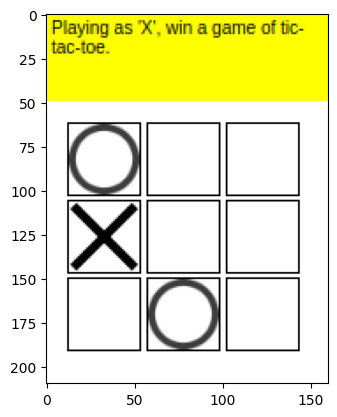

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(image)

In [21]:
np.array(['a','b'])

array(['a', 'b'], dtype='<U1')